# 1. 问题描述
本次作业中，将选择1个数据集进行频繁模式和关联规则挖掘。
# 2. 数据说明
数据集包括：
*   Consumer & Visitor Insights For Neighborhoods
*   Wine Reviews
*   Oakland Crime Statistics 2011 to 2016
*   Chicago Building Violations
*   Trending YouTube Video Statistics
*   Melbourne Airbnb Open Data
*   MLB Pitch Data 2015-2018

与第一次互评作业的数据集范围是相同的，在选择的时候可以选择之前预处理的数据集，也可以重新选择一个。

# 3. 数据分析要求
*   对数据集进行处理，转换成适合进行关联规则挖掘的形式；
*   找出频繁模式；
*   导出关联规则，计算其支持度和置信度；
*   对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种；
*   对挖掘结果进行分析；
*   可视化展示。

# 数据集Wine Reviews

---
## Description
### Context
After watching Somm (a documentary on master sommeliers) I wondered how I could create a predictive model to identify wines through blind tasting like a master sommelier would. The first step in this journey was gathering some data to train a model. I plan to use deep learning to predict the wine variety using words in the description/review. The model still won't be able to taste the wine, but theoretically it could identify the wine based on a description that a sommelier could give. If anyone has any ideas on how to accomplish this, please post them!


---


### Content
This dataset contains three files:

winemag-data-130k-v2.csv contains 10 columns and 130k rows of wine reviews.

winemag-data_first150k.csv contains 10 columns and 150k rows of wine reviews.

winemag-data-130k-v2.json contains 6919 nodes of wine reviews.

Click on the data tab to see individual file descriptions, column-level metadata and summary statistics.


---


### Acknowledgements
The data was scraped from WineEnthusiast during the week of June 15th, 2017. The code for the scraper can be found here if you have any more specific questions about data collection that I didn't address.

UPDATE 11/24/2017 After feedback from users of the dataset I scraped the reviews again on November 22nd, 2017. This time around I collected the title of each review, which you can parse the year out of, the tasters name, and the taster's Twitter handle. This should also fix the duplicate entry issue.


---


### Inspiration
I think that this dataset offers some great opportunities for sentiment analysis and other text related predictive models. My overall goal is to create a model that can identify the variety, winery, and location of a wine based on a description. If anyone has any ideas, breakthroughs, or other interesting insights/models please post them.


In [1]:
!pip3 install tqdm

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import re
import sys
import csv

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive') # mount google drive
co_path = '/content/drive/My Drive/Colab Notebooks/datamining'
os.chdir(co_path)
os.listdir(co_path)

Mounted at /content/drive


['wine_review', 'Chicago_Building_Violations', 'wine_result']

In [4]:
from tqdm import tqdm
from progressbar import *

class Association(object):
    #首先找出所有频繁项集，然后由频繁项集产生强关联规则
    def __init__(self, min_support = 0.1, min_confidence = 0.5):
        self.min_support = min_support         # 最小支持度
        self.min_confidence = min_confidence   #  最小置信度

    def apriori(self, dataset):
        """
        Apriori algorithm
        dataset:数据集，类型为一个list，list中每个元素是一个dict，key为属性名，value为对应属性的取值
        返回生成的频繁项集
        """
        C1 = self.create_C1(dataset)
        dataset = [set(data) for data in dataset]
        L1, support_data = self.scan_D(dataset, C1)
        L = [L1]
        k = 2
        while len(L[k-2]) > 0:
            Ck = self.apriori_gen(L[k-2], k)
            Lk, support_k = self.scan_D(dataset, Ck)
            support_data.update(support_k)
            L.append(Lk)
            k += 1
        return L, support_data

    def create_C1(self, dataset):
        """
        构建全部可能的单元素候选项集合(list)
        每个单元素候选项：（属性名，属性取值）
        """
        C1 = []
        progress = ProgressBar()
        for data in progress(dataset):
            for item in data:
                if [item] not in C1:
                    C1.append([item])
        return [frozenset(item) for item in C1]

    def scan_D(self, dataset, Ck):
        """
        根据待选项集Ck的情况，判断数据集D中Ck元素的出现频率
        过滤掉低于最小支持度的项集
        """
        Ck_count = dict()
        for data in dataset:
            for cand in Ck:
                if cand.issubset(data):
                    if cand not in Ck_count:
                        Ck_count[cand] = 1
                    else:
                        Ck_count[cand] += 1

        num_items = float(len(dataset))
        return_list = []
        support_data = dict()
        # 过滤非频繁项集
        for key in Ck_count:
            support  = Ck_count[key] / num_items
            if support >= self.min_support:
                return_list.insert(0, key)
            support_data[key] = support
        return return_list, support_data

    def apriori_gen(self, Lk, k):
        #合并元素时容易出现重复,针对包含k个元素的频繁项集，对比每个频繁项集第k-2位是否一致
        return_list = []
        len_Lk = len(Lk)
        for i in range(len_Lk):
            for j in range(i+1, len_Lk):
                # 第k-2个项相同时，将两个集合合并
                L1 = list(Lk[i])[:k-2]
                L2 = list(Lk[j])[:k-2]
                L1.sort()
                L2.sort()
                if L1 == L2:
                    return_list.append(Lk[i] | Lk[j])
        return return_list

    def generate_rules(self, L, support_data):
        """
        强关联规则
        基于Apriori算法，首先从一个频繁项集开始，接着创建一个规则列表，
        其中规则右部只包含一个元素，然后对这些规则进行测试。
        接下来合并所有的剩余规则列表来创建一个新的规则列表，
        其中规则右部包含两个元素。这种方法称作分级法。
        L: 频繁项集
        support_data: 频繁项集对应的支持度
        返回强关联规则列表
        """
        big_rules_list = []
        for i in range(1, len(L)):
            for freq_set in L[i]:
                H1 = [frozenset([item]) for item in freq_set]
                # 只获取有两个或更多元素的集合
                if i > 1:
                    self.rules_from_conseq(freq_set, H1, support_data, big_rules_list)
                else:
                    self.cal_conf(freq_set, H1, support_data, big_rules_list)
        return big_rules_list

    def rules_from_conseq(self, freq_set, H, support_data, big_rules_list):
        # H->出现在规则右部的元素列表
        m = len(H[0])
        if len(freq_set) > (m+1):
            Hmp1 = self.apriori_gen(H, m+1)
            Hmp1 = self.cal_conf(freq_set, Hmp1, support_data, big_rules_list)
            if len(Hmp1) > 1:
                self.rules_from_conseq(freq_set, Hmp1, support_data, big_rules_list)

    def cal_conf(self, freq_set, H, support_data, big_rules_list):
        # 评估生成的规则
        prunedH = []
        for conseq in H:
            sup = support_data[freq_set]
            conf = sup / support_data[freq_set - conseq]
            lift = conf / support_data[freq_set - conseq]
            jaccard = sup / (support_data[freq_set - conseq] + support_data[conseq] - sup)
            if conf >= self.min_confidence:
                big_rules_list.append((freq_set-conseq, conseq, sup, conf, lift,jaccard))
                prunedH.append(conseq)
        return prunedH

In [5]:
class OCS_dataset():
    def __init__(self,data_file_path,result_path,feature_list=None):
        self.data_file_path = data_file_path
        self.feature_list = feature_list
        self.result_path = result_path

    def set_feature_list(self,feature_list):
        self.feature_list = feature_list
        
    def set_data_file_path(self,data_file_path):
        self.data_file_path = data_file_path
    
    def set_result_path(result_path):
        self.result_path = result_path
    
    def data_read(self):

        data150 = pd.read_csv(self.data_file_path+"/winemag-data_first150k.csv", encoding="utf-8")
        data130 = pd.read_csv(self.data_file_path+"/winemag-data-130k-v2.csv", encoding="utf-8")

        order=["country", "description", "designation", "points", "price", 
               "province", "region_1", "region_2", "variety", "winery"]
        data150_2 = data150[order]; data130_2 = data130[order]; 

        data_all = pd.concat([data150_2, data130_2],axis=0)
        print("合并后的数据集:"); print(data_all.info())
        data_all = data_all.dropna(how='any')

        return data_all


    def mining(self,min_support = 0.1, min_confidence = 0.5,head_n=None):
        out_path = self.result_path
        association = Association(min_support=min_support,min_confidence=min_confidence)
        data_all = self.data_read()
        rows = None
        if head_n is None:
          rows = data_all.values.tolist()
        else:
          rows = data_all.head(head_n).values.tolist()

        # 将数据转为数据字典存储
        dataset = []
        feature_names = ["country", "description", "designation", "points", "price", 
               "province", "region_1", "region_2", "variety", "winery"]
        for data_line in rows:
            data_set = []
            for i, value in enumerate(data_line):
                if not value:
                    data_set.append((feature_names[i], 'NA'))
                else:
                    data_set.append((feature_names[i], value))
            dataset.append(data_set)
        print("挖掘开始")
        # 获取频繁项集
        freq_set, sup_rata = association.apriori(dataset)
        sup_rata_out = sorted(sup_rata.items(), key=lambda d: d[1], reverse=True)
        # 获取强关联规则列表
        strong_rules_list = association.generate_rules(freq_set, sup_rata)
        strong_rules_list = sorted(strong_rules_list, key=lambda x: x[3], reverse=True)

        print("挖掘完成！")
        # 将频繁项集输出到结果文件
        freq_set_file = open(os.path.join(out_path, 'frequent_iterms.json'), 'w')
        for (key, value) in sup_rata_out:
            result_dict = {'set': None, 'sup': None}
            set_result = list(key)
            sup_result = value
            if sup_result < association.min_support:
                continue
            result_dict['set'] = set_result
            result_dict['sup'] = sup_result
            json_str = json.dumps(result_dict, ensure_ascii=False)
            freq_set_file.write(json_str + '\n')
        freq_set_file.close()

        # 将关联规则输出到结果文件
        rules_file = open(os.path.join(out_path, 'rules.json'), 'w')
        for result in strong_rules_list:
            result_dict = {'X_set': None, 'Y_set': None, 'sup': None, 'conf': None, 'lift': None, 'jaccard': None}
            X_set, Y_set, sup, conf, lift, jaccard = result
            result_dict['X_set'] = list(X_set)
            result_dict['Y_set'] = list(Y_set)
            result_dict['sup'] = sup
            result_dict['conf'] = conf
            result_dict['lift'] = lift
            result_dict['jaccard'] = jaccard

            json_str = json.dumps(result_dict, ensure_ascii=False)
            rules_file.write(json_str + '\n')
        rules_file.close()
        print("结果存储完成！")

In [6]:
ocs = OCS_dataset(data_file_path="./wine_review",
                 result_path="./wine_result")
ocs.mining(min_support = 0.1, min_confidence = 0.5,head_n=50000)

合并后的数据集:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 280901 entries, 0 to 129970
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      280833 non-null  object 
 1   description  280901 non-null  object 
 2   designation  197701 non-null  object 
 3   points       280901 non-null  int64  
 4   price        258210 non-null  float64
 5   province     280833 non-null  object 
 6   region_1     234594 non-null  object 
 7   region_2     111464 non-null  object 
 8   variety      280900 non-null  object 
 9   winery       280901 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 23.6+ MB
None


  1% (611 of 50000) |                    | Elapsed Time: 0:00:00 ETA:   0:00:08

挖掘开始


100% (50000 of 50000) |##################| Elapsed Time: 0:05:46 Time:  0:05:46


挖掘完成！
结果存储完成！


# 可视化结果

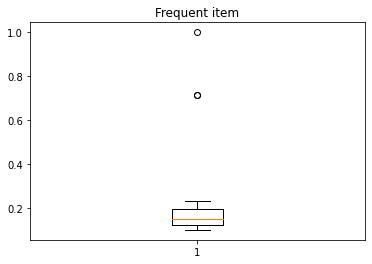

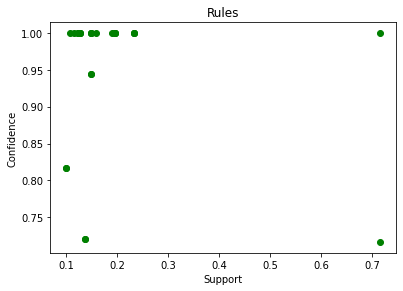

In [7]:
with open("./wine_result/frequent_iterms.json") as f1:
  freq = [json.loads(each) for each in f1.readlines()]
  freq_sup = [each["sup"] for each in freq]
  plt.figure()
  plt.title("Frequent item")
  plt.boxplot(freq_sup)
  plt.show()

with open("./wine_result/rules.json") as f2:
  rules = [json.loads(each) for each in f2.readlines()]
  rules_sup = [each["sup"] for each in rules]
  rules_conf = [each["conf"] for each in rules]
  fig=plt.figure("rule")
  ax=fig.add_axes([0.1,0.1,0.8,0.8])
  ax.set_title("Rules")
  ax.scatter(rules_sup, rules_conf, marker='o', color='green')
  ax.set_xlabel("Support")
  ax.set_ylabel("Confidence")
  plt.show()

# 结果分析
## 频繁项集
频繁项集按照支持度由大到小排序，结果如下：

In [8]:
freq

[{'set': [['country', 'US']], 'sup': 1.0},
 {'set': [['province', 'California']], 'sup': 0.71612},
 {'set': [['country', 'US'], ['province', 'California']], 'sup': 0.71612},
 {'set': [['region_2', 'Central Coast']], 'sup': 0.23342},
 {'set': [['region_2', 'Central Coast'], ['province', 'California']],
  'sup': 0.23342},
 {'set': [['country', 'US'], ['region_2', 'Central Coast']], 'sup': 0.23342},
 {'set': [['country', 'US'],
   ['region_2', 'Central Coast'],
   ['province', 'California']],
  'sup': 0.23342},
 {'set': [['region_2', 'Sonoma']], 'sup': 0.19716},
 {'set': [['province', 'California'], ['region_2', 'Sonoma']], 'sup': 0.19716},
 {'set': [['country', 'US'], ['region_2', 'Sonoma']], 'sup': 0.19716},
 {'set': [['country', 'US'],
   ['province', 'California'],
   ['region_2', 'Sonoma']],
  'sup': 0.19716},
 {'set': [['variety', 'Pinot Noir']], 'sup': 0.19056},
 {'set': [['country', 'US'], ['variety', 'Pinot Noir']], 'sup': 0.19056},
 {'set': [['province', 'Washington']], 'sup': 0

## 关联规则
将关联规则按照置信度由大到小排序，结果如下。分析可知points的置信度最高，说明葡萄酒的品种属于美国的比较多。

In [9]:
rules

[{'X_set': [['points', 87]],
  'Y_set': [['country', 'US']],
  'conf': 1.0,
  'jaccard': 0.12466,
  'lift': 8.021819348628268,
  'sup': 0.12466},
 {'X_set': [['points', 88]],
  'Y_set': [['country', 'US']],
  'conf': 1.0,
  'jaccard': 0.1083,
  'lift': 9.233610341643583,
  'sup': 0.1083},
 {'X_set': [['points', 90]],
  'Y_set': [['country', 'US']],
  'conf': 1.0,
  'jaccard': 0.1152,
  'lift': 8.680555555555555,
  'sup': 0.1152},
 {'X_set': [['province', 'Washington']],
  'Y_set': [['country', 'US']],
  'conf': 1.0,
  'jaccard': 0.15882,
  'lift': 6.296436217101121,
  'sup': 0.15882},
 {'X_set': [['region_2', 'Columbia Valley']],
  'Y_set': [['country', 'US']],
  'conf': 1.0,
  'jaccard': 0.15006,
  'lift': 6.6640010662401705,
  'sup': 0.15006},
 {'X_set': [['region_2', 'Columbia Valley']],
  'Y_set': [['province', 'Washington']],
  'conf': 1.0,
  'jaccard': 0.9448432187381942,
  'lift': 6.6640010662401705,
  'sup': 0.15006},
 {'X_set': [['region_2', 'Central Coast']],
  'Y_set': [['co